In [40]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
import sys
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
from ExKMC.Tree import Tree as ExTree

sys.path.append("../main")
from tree import *
from rules import *
from tree_rules import *
from rule_clustering import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 342
np.random.seed(seed)

# Dataset

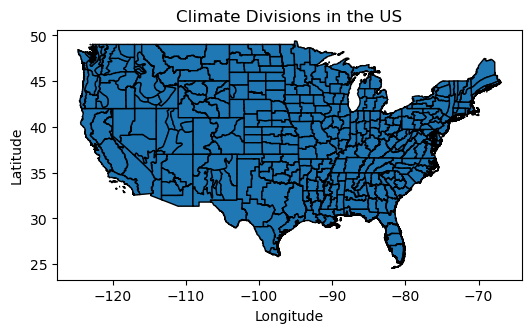

In [19]:
shapefile_path = '../data/climate_divisions/climate_divisions.shp'
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shapefile_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

gdf.plot(figsize=(6, 6), edgecolor='black')
plt.title('Climate Divisions in the US')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [20]:
climate_data = pd.read_csv('../data/climate.csv', dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

In [21]:
climate_data

pcpn_jan  pcpn_feb  pcpn_mar  pcpn_apr  pcpn_may  pcpn_june  \
ID   Year                                                                
0101 1895      7.37      1.41      7.17      2.72      3.06       4.04   
     1896      2.47      7.46      6.23      4.34      2.92       4.50   
     1897      3.85      3.74     14.40      4.99      2.87       2.12   
     1898      7.07      1.34      4.43      4.29      1.86       2.61   
     1899      5.79      6.39      9.93      2.99      1.50       2.22   
...             ...       ...       ...       ...       ...        ...   
5013 2020      3.21      4.60      2.03      1.40      2.04       1.94   
     2021      5.02      5.64      3.09      2.64      2.79       2.50   
     2022      3.44      7.17      2.51      2.76      0.70       2.34   
     2023      3.71      3.83      4.87      1.88      3.27       2.06   
     2024      5.53      3.97      4.03      3.44      2.36       1.80   

           pcpn_july  pcpn_aug  pcpn_sept  pcpn_oct  ...  temp_mar  temp_apr  \
ID   Year                                            ...                       
0101 1895       4.58      4.00       3.41      2.28  ...      50.3      61.2   
     1896       3.78      1.94       2.67      1.59  ...      47.8      65.7   
     1897       3.93      3.66       0.03      1.74  ...      55.2      60.0   
     1898       5.52      3.67       2.83      3.72  ...      56.0      55.4   
     1899       6.04      3.44       0.57      1.85  ...      51.0      59.1   
...              ...       ...        ...       ...  ...       ...       ...   
5013 2020       2.76      3.24       6.04      4.18  ...      33.2      38.6   
     2021       2.09      2.61       3.53      9.21  ...      31.9      36.8   
     2022       2.96      6.06       4.25      5.75  ...      30.5      34.9   
     2023       5.39      2.87       5.34      3.34  ...      33.1      34.2   
     2024       3.74     -9.99      -9.99     -9.99  ...      29.5      35.2   

           temp_may  temp_june  temp_july  temp_aug  temp_sept  temp_oct  \
ID   Year                                                                  
0101 1895      66.8       75.8       77.0      78.1       75.2      54.3   
     1896      73.8       74.8       79.9      80.8       72.0      58.6   
     1897      66.1       78.5       80.2      77.8       74.8      64.8   
     1898      71.8       79.1       79.8      78.5       74.6      58.5   
     1899      74.3       78.8       79.9      80.8       71.0      64.2   
...             ...        ...        ...       ...        ...       ...   
5013 2020      42.2       47.4       52.0      50.9       45.5      40.9   
     2021      41.3       46.7       50.7      51.8       47.3      39.7   
     2022      39.7       46.9       50.0      51.1       48.4      41.8   
     2023      39.0       46.1       51.9      52.4       48.3      42.3   
     2024      38.4       44.7       50.3     -99.9      -99.9     -99.9   

           temp_nov  temp_dec  
ID   Year                      
0101 1895      50.1      42.1  
     1896      52.9      42.7  
     1897      50.3      43.1  
     1898      46.4      39.6  
     1899      53.0      39.9  
...             ...       ...  
5013 2020      36.3      30.6  
     2021      29.2      34.7  
     2022      37.3      33.7  
     2023      37.3      28.1  
     2024     -99.9     -99.9  

[46020 rows x 24 columns]

In [22]:
historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]

historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]

historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]

# Some extra code for filtering instances with large values:
#threshold = 10

# Create a boolean mask where any value in a row is greater than the threshold
#mask = ((climate_change > threshold) | (climate_change < -threshold)).any(axis=1)

# Filter the DataFrame based on the mask
#climate_change = climate_change[~mask]

In [23]:
climate_change

,pcpn_jan,pcpn_feb,pcpn_mar,pcpn_apr,pcpn_may,pcpn_june,pcpn_july,pcpn_aug,pcpn_sept,pcpn_oct,...,temp_mar,temp_apr,temp_may,temp_june,temp_july,temp_aug,temp_sept,temp_oct,temp_nov,temp_dec
ID,,,,,,,,,,,,,,,,,,,,,
2905,-0.030938,-0.217248,-0.320671,-0.404069,-0.204052,0.099656,0.056529,-0.162086,0.102329,-0.081426,...,0.077082,0.051805,0.028818,0.046744,0.038059,0.027483,0.041528,0.033872,0.060658,0.084255
2906,-0.156157,-0.299656,-0.216950,-0.310281,-0.229890,0.068542,-0.007252,-0.089024,0.028885,0.200843,...,0.087135,0.049023,0.027016,0.050387,0.044145,0.032264,0.049500,0.035546,0.058297,0.095653
1001,-0.098737,-0.040897,0.175809,0.098883,0.022068,-0.010902,-0.523080,-0.152467,-0.020648,0.101543,...,0.054926,0.006235,0.057019,0.046189,0.053419,0.060739,0.040385,0.027022,0.049622,0.042960
1002,-0.176396,0.214123,0.065458,0.097268,-0.051057,-0.084923,-0.598397,-0.219392,-0.124723,0.036413,...,0.042998,0.010755,0.043730,0.039428,0.043267,0.045884,0.034240,0.018335,0.030591,0.016510
1004,-0.211153,0.062531,0.041653,0.036466,-0.060523,-0.101367,-0.459143,-0.070443,0.055347,0.038356,...,0.084455,0.016827,0.043524,0.048410,0.047718,0.044913,0.040256,0.025190,0.056796,0.054584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,0.031042,-0.391871,-0.219543,-0.358479,-0.239484,-0.088902,-0.101613,-0.063409,0.083249,0.375396,...,0.069497,0.031402,0.033017,0.046295,0.044481,0.037665,0.047976,0.033209,0.048690,0.093984
2901,0.147762,-0.117873,-0.185905,-0.483620,0.011190,-0.219368,-0.000435,-0.230803,0.017734,-0.286191,...,0.075447,0.041657,0.021077,0.052608,0.037410,0.028883,0.048531,0.023130,0.061275,0.075415
2902,0.093447,-0.111407,-0.128909,-0.402782,-0.074226,-0.083968,0.125937,-0.198664,0.123867,-0.010117,...,0.084182,0.036015,0.018593,0.043957,0.030458,0.019877,0.049445,0.026987,0.067528,0.093846


<Axes: >

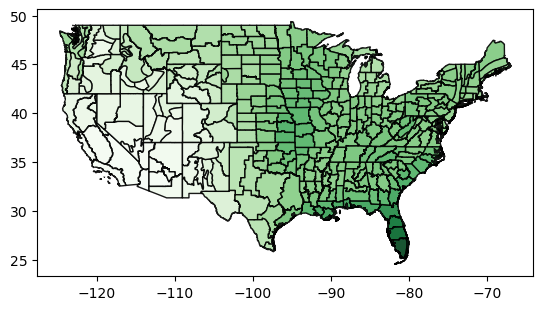

In [24]:
var = 'pcpn_june'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(historical_avg.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = historical_avg.loc[id, var]

gdf['val'] = val_array
gdf.plot(column='val', cmap='Greens', legend=False, edgecolor = 'black', alpha = 0.9)

<Axes: >

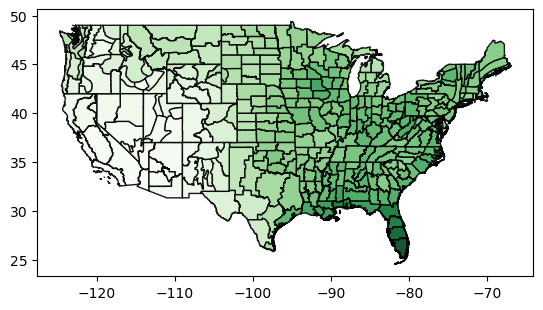

In [25]:
var = 'pcpn_june'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(recent_avg.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = recent_avg.loc[id, var]
        
gdf['val'] = val_array
gdf.plot(column='val', cmap='Greens', legend=False, edgecolor = 'black', alpha = 0.9)

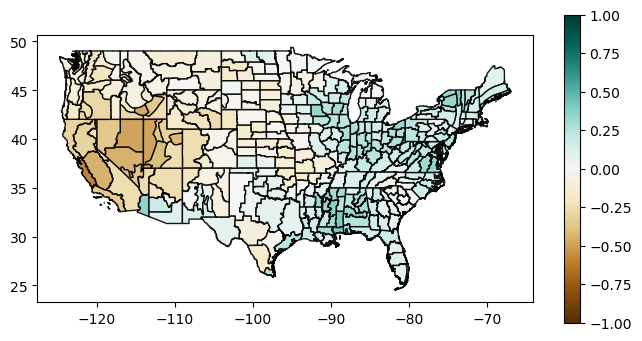

In [26]:
var = 'pcpn_june'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = climate_change.loc[id, var]
        
gdf['val'] = val_array

fig,ax = plt.subplots(figsize = (8,8))
gdf.plot(column='val', cmap='BrBG', ax = ax, vmin = -1, vmax = 1, legend=False, edgecolor = 'black', alpha = 0.9)
sm = plt.cm.ScalarMappable(cmap='BrBG', norm=plt.Normalize(vmin=-1, vmax=1))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink = 0.5)

# Clustering

In [27]:
data = climate_change.to_numpy()
feature_labels = climate_change.columns

## k-means

In [28]:
k_trials = list(range(2,41))
trial_scores = [-1]*len(k_trials)
for i,k in enumerate(k_trials):
    kmeans = KMeans(n_clusters=k, init = 'k-means++', n_init='auto', random_state = seed).fit(data)
    kmeans_clustering = labels_to_clustering(kmeans.labels_)
    trial_scores[i] = kmeans_cost(data, kmeans_clustering, kmeans.cluster_centers_)
    #trial_scores[i] = silhouette_score(data, kmeans.labels_)

Text(0, 0.5, 'cost')

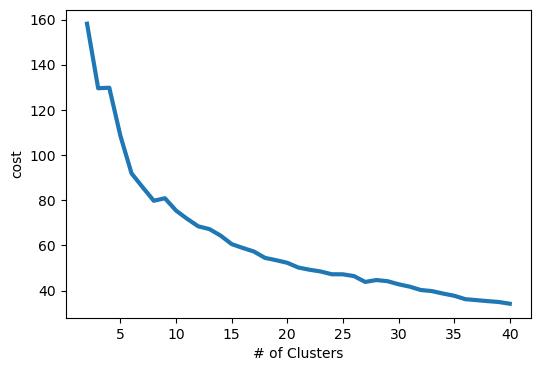

In [29]:
fig,ax = plt.subplots(figsize = (6,4))
ax.plot(k_trials, trial_scores, linewidth = 3)
ax.set_xlabel('# of Clusters')
ax.set_ylabel('cost')

In [36]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=seed, n_init="auto").fit(data)

In [31]:
kmeans_clustering = labels_to_clustering(kmeans.labels_)
kmeans_cost(data, kmeans_clustering, kmeans.cluster_centers_)

91.89185010150574

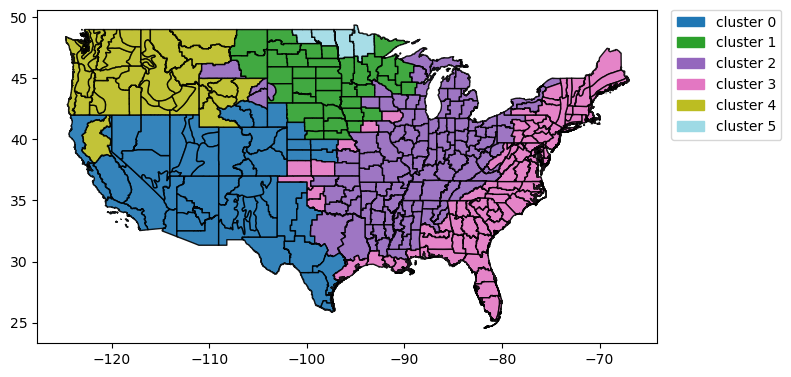

In [32]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = kmeans.labels_[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap='tab20', ax = ax, legend=False, edgecolor = 'black', alpha = 0.9)

legend_labels = np.unique(label_array)
cmap = plt.get_cmap('tab20')
norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))

patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

In [52]:
ExKMC_tree = ExTree(k, max_leaves = 2*k)
exkmc_labels = ExKMC_tree.fit_predict(data, kmeans)
exkmc_clustering = labels_to_clustering(exkmc_labels)
exkmc_centers = ExKMC_tree.all_centers
exkmc_cost = kmeans_cost(data, exkmc_clustering, exkmc_centers)

## Rule Clustering

In [53]:
k = 6

#### k-means Tree Partition

In [54]:
leaves = list(range(k,37))
cost_by_leaves = []
for l in leaves:
    kmeans_tree = KMeansTree(max_leaf_nodes = l, min_points_leaf = 1)
    kmeans_tree.fit(data)
    kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)

    cost_sum = 0
    for r in kmeans_rules:
        r.fit(data)
        mu_r = np.mean(r.satisfied_points, axis = 0)
        cost_sum += np.sum((r.satisfied_points - mu_r)**2)

    cost_by_leaves.append(cost_sum)

NameError: name 'cost' is not defined

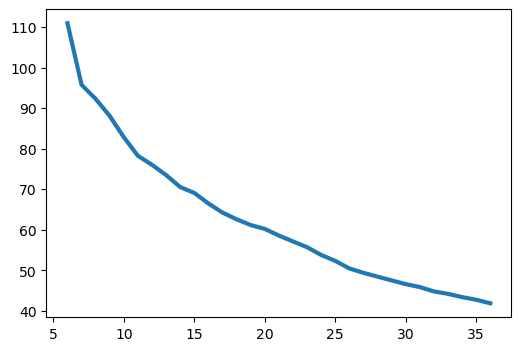

In [55]:
fig,ax = plt.subplots(figsize = (6,4))
plt.plot(leaves, cost_by_leaves, linewidth = 3, label = 'Tree')
plt.hlines(cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'k-means', linewidth = 3)
plt.legend()
ax.set_xlabel('# of leaves')
ax.set_ylabel('Cost')

In [ ]:
cost

In [56]:
cost = kmeans_cost(data, kmeans_clustering, kmeans.cluster_centers_)
upper_bound = 4*cost + 6*np.array(cost_by_leaves)
dasgupta = k**2 * cost
svensson = k * (np.log(k)**2) * cost

Text(0, 0.5, 'Cost')

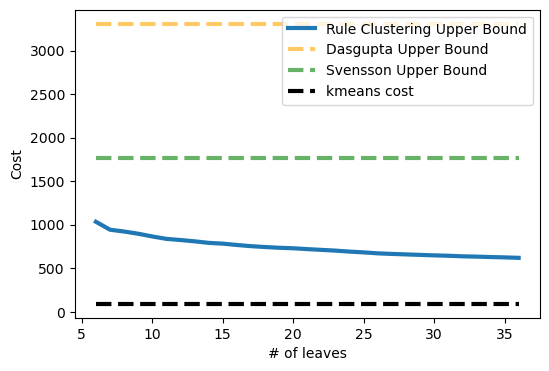

In [57]:
fig,ax = plt.subplots(figsize = (6,4))
plt.plot(leaves, upper_bound, linewidth = 3, label = 'Rule Clustering Upper Bound')
plt.hlines(dasgupta, xmin = leaves[0], xmax = leaves[-1], linestyle = '--', label = 'Dasgupta Upper Bound', linewidth = 3, color = 'orange', alpha = 0.6)
plt.hlines(svensson, xmin = leaves[0], xmax = leaves[-1], linestyle = '--', label = 'Svensson Upper Bound', linewidth = 3, color = 'green', alpha = 0.6)
plt.hlines(cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'kmeans cost', linewidth = 3)
plt.legend()
ax.set_xlabel('# of leaves')
ax.set_ylabel('Cost')

In [58]:
kmeans_tree = KMeansTree(max_leaf_nodes = 12, min_points_leaf = 1)
kmeans_tree.fit(data, feature_labels)
kmeans_tree_labels = kmeans_tree.predict(data)
tree_traverse = tree_to_rules()
kmeans_tree_rules = tree_traverse.traverse(kmeans_tree.root)
leaf_node_labels = tree_traverse.leaf_node_labels

In [59]:
tree_to_rules().traverse(kmeans_tree.root)

[(temp_apr <= -0.0356369820655536  ∧  temp_jan <= 1.2232939474318787),
 (temp_apr <= -0.0356369820655536  ∧  temp_jan > 1.2232939474318787),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan <= 0.03969656140292623  ∧  pcpn_aug <= 0.09240585111054267),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan <= 0.03969656140292623  ∧  pcpn_aug > 0.09240585111054267),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan > 0.03969656140292623  ∧  temp_apr <= 0.01620793806100326),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616  ∧  temp_jan > 0.03969656140292623  ∧  temp_apr > 0.01620793806100326),
 (temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb > 0.13330478404502616  ∧  pcpn_sept <= -0.093328455265363),


#### Rule constrained k-means

In [60]:
rule_kmeans = KMeansRuleClustering(kmeans_tree_rules, k_clusters = k, init = 'k-means', max_iterations = 500, 
                                   random_seed = seed, cost_tracker = True)
rule_kmeans.fit(data)
rule_labels = rule_kmeans.labels
data_clustering, data_labels = rule_kmeans.predict(data)

In [61]:
rule_kmeans.cost_per_iteration

[102.94377508606682]

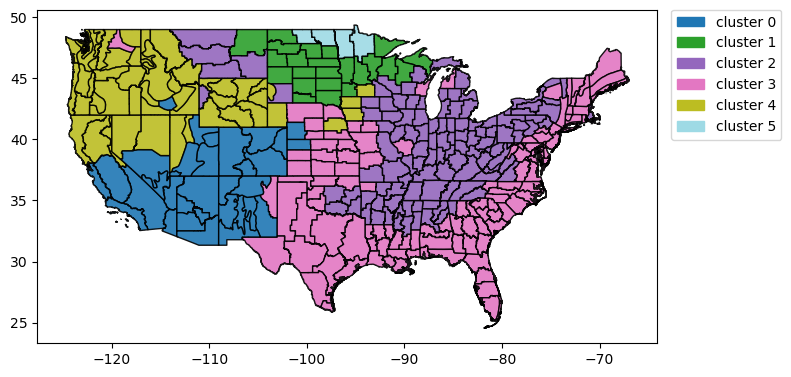

In [62]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = data_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8), dpi = 100)
gdf.plot(column='cluster', cmap='tab20', ax = ax, legend=False, edgecolor = 'black', alpha = 0.9)

legend_labels = np.unique(label_array)
cmap = plt.get_cmap('tab20')
norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))

patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

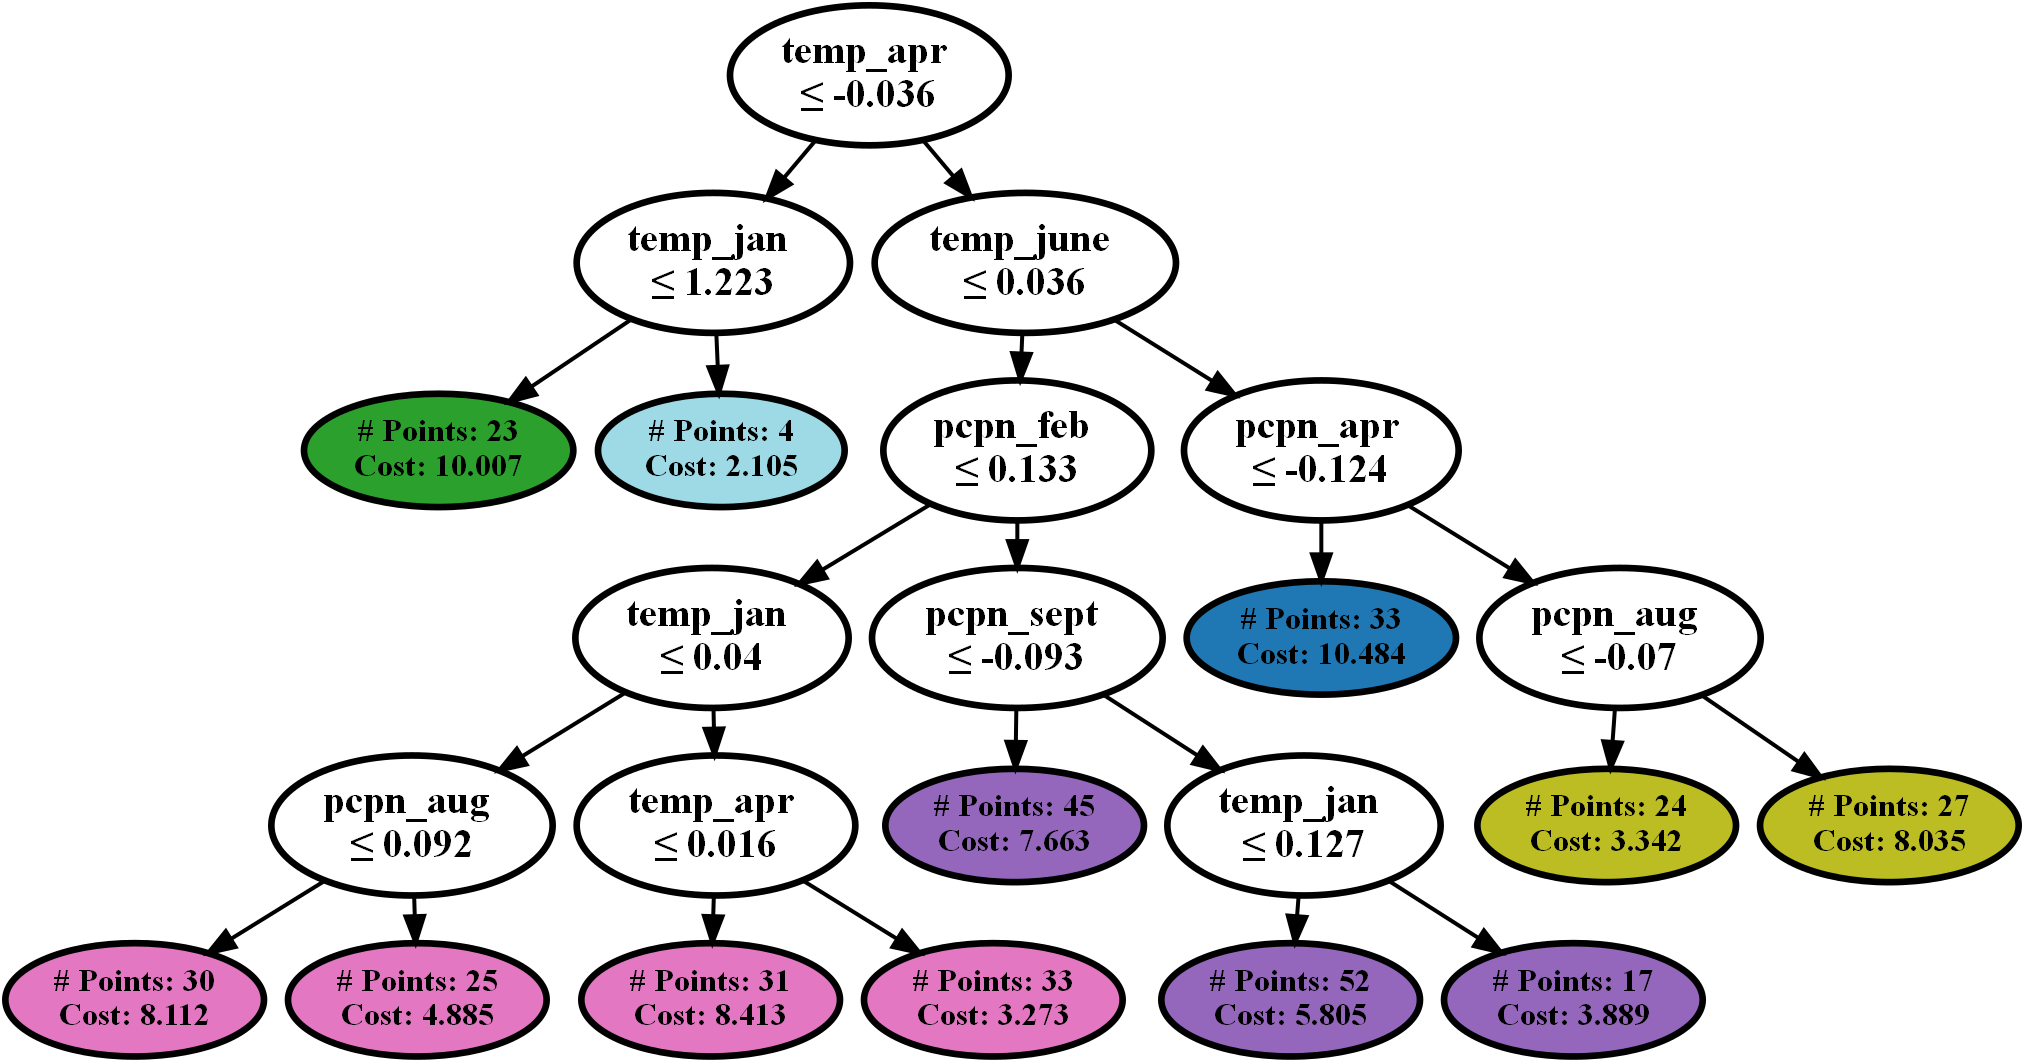

In [63]:
leaf_colors = {leaf_node_labels[i]:mcolors.rgb2hex(cmap(norm(rule_labels[i])), keep_alpha=True) for i in range(len(leaf_node_labels))}
visualize_tree(kmeans_tree.root, feature_labels = feature_labels, leaf_colors = leaf_colors)

In [64]:
print(rule_kmeans)

IF:
(temp_apr > -0.0356369820655536  ∧  temp_june > 0.03600812668405327  ∧  pcpn_apr <= -0.12371914592902933)
THEN CLUSTER 0

IF:
(temp_apr <= -0.0356369820655536  ∧  temp_jan <= 1.2232939474318787)
THEN CLUSTER 1

IF:
(temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb > 0.13330478404502616)
THEN CLUSTER 2

IF:
(temp_apr > -0.0356369820655536  ∧  temp_june <= 0.03600812668405327  ∧  pcpn_feb <= 0.13330478404502616)
THEN CLUSTER 3

IF:
(temp_apr > -0.0356369820655536  ∧  temp_june > 0.03600812668405327  ∧  pcpn_apr > -0.12371914592902933)
THEN CLUSTER 4

IF:
(temp_apr <= -0.0356369820655536  ∧  temp_jan > 1.2232939474318787)
THEN CLUSTER 5



In [65]:
# Revert the seed in case it has been advanced anywhere else:
np.random.seed(seed)

leaves = list(range(k,len(data)))
cost_by_leaves1 = []
iterations1 = []
cost_by_leaves2 = []
iterations2 = []

for l in leaves:
    kmeans_tree = KMeansTree(max_leaf_nodes = l, min_points_leaf = 1)
    kmeans_tree.fit(data)
    kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)
    
    rule_kmeans1 = KMeansRuleClustering(kmeans_rules, k_clusters = k, init = 'k-means', max_iterations = 1000)
    rule_kmeans1.fit(data)
    data_clustering1, data_labels1 = rule_kmeans1.predict(data)
    iterations1.append(rule_kmeans1.iterations)

    rule_kmeans2 = KMeansRuleClustering(kmeans_rules, k_clusters = k, init = 'k-means++', max_iterations = 1000)
    rule_kmeans2.fit(data)
    data_clustering2, data_labels2 = rule_kmeans2.predict(data)
    iterations2.append(rule_kmeans1.iterations)

    cluster_cost = kmeans_cost(data, data_clustering1, rule_kmeans1.centers)
    cost_by_leaves1.append(cluster_cost)

    cluster_cost = kmeans_cost(data, data_clustering2, rule_kmeans2.centers)
    cost_by_leaves2.append(cluster_cost)

In [66]:
# Svensson Random Tree for comparison:

# Revert the seed in case it has been advanced anywhere else:
np.random.seed(seed)

random_tree_cost = np.inf
for i in range(10000):
    random_tree = RandomTree(max_leaf_nodes = k, min_points_leaf = 1)
    random_tree.fit(kmeans.cluster_centers_)
    random_tree_labels = random_tree.predict(data)
    random_tree_clustering = labels_to_clustering(random_tree_labels)
    random_tree_centers = np.vstack([data[cluster,:].mean(axis = 0) for cluster in random_tree_clustering])
    #rcost = kmeans_cost(data, random_tree_clustering, kmeans.cluster_centers_)
    rcost = kmeans_cost(data, random_tree_clustering, random_tree_centers)
    if rcost < random_tree_cost:
        random_tree_cost = rcost

C:\Users\kq146\AppData\Local\Temp\ipykernel_1304\598831011.py:12: RuntimeWarning: Mean of empty slice.
  random_tree_centers = np.vstack([data[cluster,:].mean(axis = 0) for cluster in random_tree_clustering])
C:\Users\kq146\anaconda3\envs\ex_cluster\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Text(0, 0.5, 'cost')

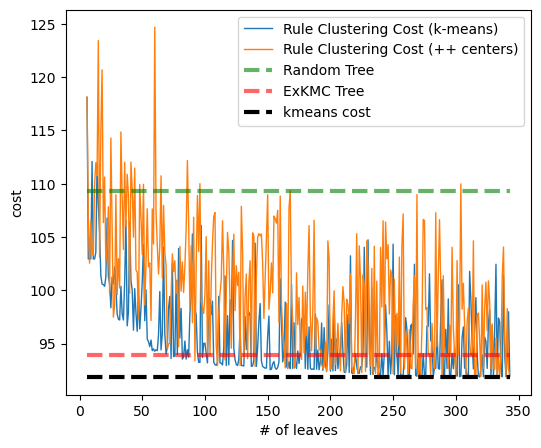

In [67]:
fig,ax = plt.subplots(figsize = (6,5))
#sns.regplot(x = leaves, y = cost_by_leaves1, order = 2, scatter_kws={'alpha':0.1}, line_kws={'linewidth': 3, 'label':'Rule Clustering (k-means)'})
#sns.regplot(x = leaves, y = cost_by_leaves2, order = 2, scatter_kws={'alpha':0.1}, line_kws={'linewidth': 3, 'label':'Rule Clustering (k-means++)'})
ax.plot(leaves, cost_by_leaves1, linewidth = 1, label = 'Rule Clustering Cost (k-means)')
ax.plot(leaves, cost_by_leaves2, linewidth = 1, label = 'Rule Clustering Cost (++ centers)')
ax.hlines(random_tree_cost, xmin = leaves[0], xmax = leaves[-1], color = 'green', linestyle = '--', label = 'Random Tree', linewidth = 3, alpha = 0.6)
ax.hlines(exkmc_cost, xmin = leaves[0], xmax = leaves[-1], color = 'red', linestyle = '--', label = 'ExKMC Tree', linewidth = 3, alpha = 0.6)
ax.hlines(kmeans_cost(data, kmeans_clustering, kmeans.cluster_centers_), xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'kmeans cost', linewidth = 3)
plt.legend()
ax.set_xlabel('# of leaves')
ax.set_ylabel('cost')

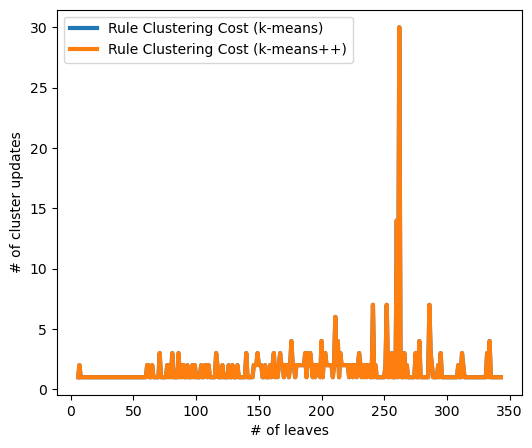

In [91]:
leaves = list(range(k,len(data)))
fig,ax = plt.subplots(figsize = (6,5))
ax.plot(leaves, iterations1, linewidth = 3, label = 'Rule Clustering Cost (k-means)')
ax.plot(leaves, iterations2, linewidth = 3, label = 'Rule Clustering Cost (++ centers)')
ax.set_xlabel('# of leaves')
ax.set_ylabel('# of cluster updates')
plt.legend()